In [3]:
import pandas as pd
import numpy as np
import json
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import plotly
import plotly.plotly as py  
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

from sklearn.preprocessing import StandardScaler  

from sklearn.metrics import mean_squared_error
import math

## 1. Data Cleaning

In [4]:
#1. json flatteing and adding as new columns
def load_df(path):
    df = pd.read_csv(path, dtype={'fullVisitorId': 'str'})
    JSON_COLS = ['totals','trafficSource','device','geoNetwork']
    for json_col in JSON_COLS: 
        inp_df = pd.DataFrame(df.pop(json_col).apply(pd.io.json.loads).values.tolist(), index=df.index)
        df = df.join(inp_df) 
     
    #json columns of columns
    inp_df = pd.DataFrame(df.pop('adwordsClickInfo').values.tolist(), index=df.index)
    df = df.join(inp_df)     
    return df

In [5]:
%%time
train_df = load_df("train.csv")
train_df.shape

Wall time: 51.7 s


In [6]:
%%time
test_df = load_df("test.csv")
test_df.shape

Wall time: 58.1 s


In [7]:
%%time
df = train_df.copy()

Wall time: 3.95 s


In [8]:
%%time
test_data = test_df.copy()

Wall time: 4.02 s


In [9]:
test_data.shape

(804684, 54)

In [10]:
# test_data.count()

In [11]:
df.shape
#df.count()

(903653, 56)

In [12]:
#2. replacing unknown values with nan
def replace_df_vals(df):
    df.replace({'(not set)': np.nan,
               'not available in demo dataset': np.nan,
               '(not provided)': np.nan,
               'unknown.unknown': np.nan,
               '(none)':np.nan,
               '/':np.nan,
               'Not Socially Engaged':np.nan},
               inplace=True) 

In [13]:
%%time
replace_df_vals(df)

Wall time: 2min 18s


In [14]:
%%time
replace_df_vals(test_data)

Wall time: 2min 39s


In [15]:
#3. drop all columns having only NaN's--- 32 from 50
df = df.dropna(axis=1, how='all')

#4. drop columns having single value and all nans
df.drop('campaignCode', axis=1, inplace=True)
# df.shape

In [16]:
#5. drop columns having single unique values
# df.newVisits.unique().tolist()
# df.bounces.unique().tolist()
df.drop('newVisits', axis=1, inplace=True)
df.drop('bounces', axis=1, inplace=True)
df.drop('targetingCriteria', axis=1, inplace=True)
df.shape

(903653, 34)

In [17]:
test_data = test_data.dropna(axis=1, how='all')
#test_data.drop('campaignCode', axis=1, inplace=True)
test_data.drop('newVisits', axis=1, inplace=True)
test_data.drop('bounces', axis=1, inplace=True)
test_data.drop('targetingCriteria', axis=1, inplace=True)
test_data.shape

(804684, 33)

In [18]:
#6 Impute 0 for missing target values
df["transactionRevenue"].fillna(0, inplace=True)

In [19]:
df["pageviews"].fillna(0, inplace=True)
df["pageviews"] = df["pageviews"].astype('float')
df["hits"].fillna(0, inplace=True)
df["hits"] = df["hits"].astype('float')

In [20]:
test_data["pageviews"].fillna(0, inplace=True)
test_data["pageviews"] = df["pageviews"].astype('float')
test_data["hits"].fillna(0, inplace=True)
test_data["hits"] = df["hits"].astype('float')

In [21]:
test_data.shape

(804684, 33)

In [22]:
df['date'] = pd.to_datetime((df['date']).astype(str), format = '%Y-%m-%d')
df[['year', 'month', 'day']] = df['date'].astype(str).str.split('-', expand = True)    
df.drop('date', axis =1,inplace = True)

In [23]:
test_data['date'] = pd.to_datetime((test_data['date']).astype(str), format = '%Y-%m-%d')
test_data[['year', 'month', 'day']] = test_data['date'].astype(str).str.split('-', expand = True)    
test_data.drop('date', axis =1,inplace = True)

In [24]:
df["transactionRevenue"] = df["transactionRevenue"].astype('float')
df['transactionRevenue_log'] = np.log(df[df['transactionRevenue'] > 0]["transactionRevenue"] + 0.01) 

## 2. a) Revenue v/s number of people

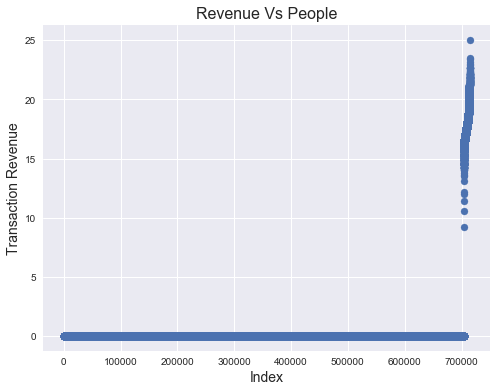

In [25]:
gdf = df.groupby("fullVisitorId")["transactionRevenue"].sum().reset_index()
fig = plt.figure(figsize=(8,6))
plt.title('Revenue Vs People', fontsize = 16) 
plt.scatter(range(gdf.shape[0]), np.sort(np.log1p(gdf["transactionRevenue"].values)))
plt.xlabel('Index', fontsize=14)
plt.ylabel('Transaction Revenue', fontsize=14)
plt.savefig('2a.png')
plt.show()

In [26]:
nonzr = (gdf["transactionRevenue"]>0).sum()
ans = (nonzr*100)/gdf.shape[0]

## 2. b) Revenue generated in the Browsers

In [27]:
print(df['browser'].value_counts()[:10] )

Chrome               620364
Safari               182245
Firefox               37069
Internet Explorer     19375
Edge                  10205
Android Webview        7865
Safari (in-app)        6850
Opera Mini             6139
Opera                  5643
UC Browser             2427
Name: browser, dtype: int64


C:\Users\rajes\Anaconda2\lib\site-packages\seaborn\categorical.py:454: FutureWarning:

remove_na is deprecated and is a private function. Do not use.



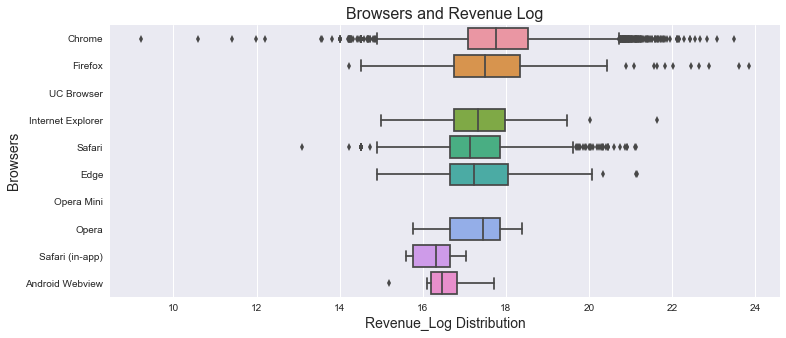

In [28]:
plt.figure(figsize=(12,5)) 
g1 = sns.boxplot(x='transactionRevenue_log', y='browser',
                   data=df[df['browser'].isin(df['browser'].value_counts()[:10].index.values)])
g1.set_title('Browsers and Revenue Log', fontsize = 16) 
g1.set_ylabel('Browsers', fontsize=14) 
g1.set_xlabel('Revenue_Log Distribution', fontsize=14) 
plt.savefig('2b.png')
plt.show()

In [29]:
# gdf = df.groupby("browser")["transactionRevenue"].sum()
# gdf

## 2. c) Channel Grouping and Browsers

Organic Search    381561
Social            226117
Direct            143026
Referral          104838
Paid Search        25326
Affiliates         16403
Display             6262
(Other)              120
Name: channelGrouping, dtype: int64


C:\Users\rajes\Anaconda2\lib\site-packages\seaborn\categorical.py:1428: FutureWarning:

remove_na is deprecated and is a private function. Do not use.



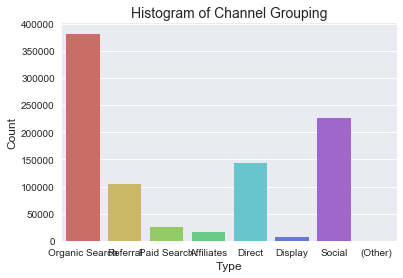

In [30]:
print df['channelGrouping'].value_counts()[:10]
sns.countplot(df["channelGrouping"], palette="hls") 
plt.title("Histogram of Channel Grouping", fontsize=14) 
plt.xlabel("Type", fontsize=12)
plt.ylabel("Count", fontsize=12) 
plt.show()

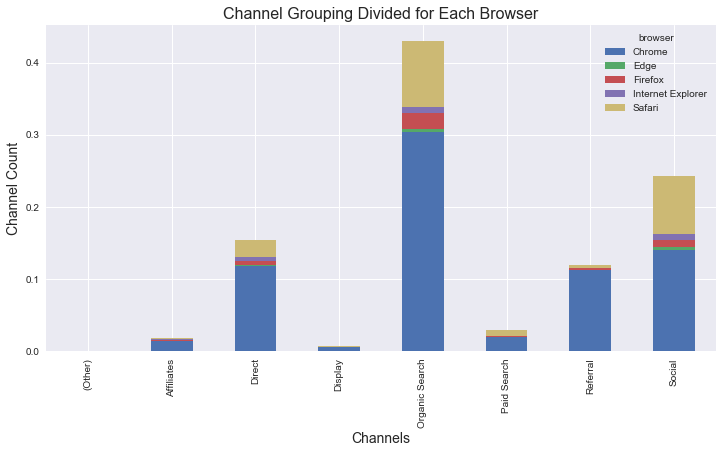

In [31]:
cgb = pd.crosstab(index=df['channelGrouping'], normalize=True, columns=df[df['browser'].isin(df['browser'].value_counts()[:5].index.values)]['browser'])
cgb.plot(kind="bar", figsize=(12,6), stacked=True)   
plt.title("Channel Grouping Divided for Each Browser", fontsize=16)
plt.xlabel("Channels", fontsize=14)
plt.ylabel("Channel Count", fontsize=14)
plt.savefig('2c.png')
plt.show() 

## 3. Clustering by Geography

In [32]:
# geoDf = df.copy()

In [33]:
# geoDf['isAsia'] = np.where(geoDf['continent'] == 'Asia', 1, 0)
# geoDf['isAmericas'] = np.where(geoDf['continent'] == 'Americas', 1, 0)
# geoDf['isOceania'] = np.where(geoDf['continent'] == 'Oceania', 1, 0)
# geoDf['isAfrica'] = np.where(geoDf['continent'] == 'Africa', 1, 0)
# geoDf['isEurope'] = np.where(geoDf['continent'] == 'Europe', 1, 0)

# geoDf.continent[geoDf.continent == "Asia"] = 1
# geoDf.continent[geoDf.continent == "Africa"] = 2
# geoDf.continent[geoDf.continent == "Oceania"] = 3 
# geoDf.continent[geoDf.continent == "Europe"] = 4
# geoDf.continent[geoDf.continent == "Americas"] = 5

In [34]:
# geoDf["continent"].fillna(0, inplace=True)

In [35]:
# geoDf1 = geoDf[['hits', 'visits', 
#           'pageviews',"isAsia","isAmericas",'isOceania',"isAfrica", 'isEurope', 'transactionRevenue']]

# # geoDf1 = geoDf[['isMobile','hits', 'visits', 
# #           'pageviews', 'transactionRevenue', 'continent']]

# #cor = geoDf1.corr() 
# #print cor
# #sns.heatmap(cor, square = True) 

In [36]:
# ss = StandardScaler()
# ss.fit_transform(geoDf1)

In [37]:
# #K means Clustering 
# def doKmeans(X, nclust=2):
#     model = KMeans(nclust)
#     model.fit(X)
#     clust_labels = model.predict(X)
#     cent = model.cluster_centers_
#     return (clust_labels, cent)

# clust_labels, cent = doKmeans(geoDf1, 2)
# kmeans = pd.DataFrame(clust_labels)
# geoDf1.insert((geoDf1.shape[1]),'kmeans',kmeans)

In [38]:
# geoDf1.hits.unique().tolist()

In [39]:
# #Plot the clusters obtained using k means
# fig = plt.figure()
# #ax = fig.add_subplot(111)
# scatter = ax.scatter(geoDf1['continent'],geoDf1['hits'],
#                      c=geoDf1.continent)
# ax.set_title('K-Means Clustering')
# ax.set_xlabel('')
# ax.set_ylabel('')
# plt.colorbar(scatter)

In [40]:
# geoDf1.count

In [41]:
# kmeans = KMeans(n_clusters = 5, n_jobs=-1).fit(geoDf1)

In [42]:
# plt.figure(figsize=(14,14))
# plt.xlabel("xx")
# plt.ylabel("yy")
# plt.scatter(geoDf1['transactionRevenue'], geoDf1["hits"], s=1, c=[matplotlib.cm.spectral(float(i) /10) for i in
#                                                                   kmeans.labels_])
# plt.show()

In [43]:
# geoDf.shape

In [44]:
# plt.figure(figsize=(14,14))
# plt.xlabel("xx")
# plt.ylabel("yy")
# plt.scatter(geoDf1['transactionRevenue'], geoDf1["hits"])
# plt.show()

In [45]:
print len(df.city.unique().tolist())
print len(df.continent.unique().tolist())
print len(df.country.unique().tolist())
print len(df.metro.unique().tolist())
print len(df.networkDomain.unique().tolist())
print len(df.subContinent.unique().tolist())

648
6
222
93
28063
23


In [46]:
gdfCountry = df.groupby(['country']).sum().reset_index()
gdfCountry.isMobile.dtype

dtype('float64')

In [47]:
gdfCountry = gdfCountry[['country','hits', 'isMobile','pageviews','transactionRevenue','transactionRevenue_log']]

In [48]:
gdfCountry.head()

,country,hits,isMobile,pageviews,transactionRevenue,transactionRevenue_log
0,Afghanistan,138.0,20.0,117.0,0.0,0.0
1,Albania,996.0,64.0,909.0,0.0,0.0
2,Algeria,3911.0,366.0,3487.0,0.0,0.0
3,American Samoa,1.0,0.0,1.0,0.0,0.0
4,Andorra,60.0,3.0,48.0,0.0,0.0


In [49]:
### Mobile Phones Used across the globe

In [50]:
data = dict(type = 'choropleth', 
           locations = gdfCountry['country'],
           locationmode = 'country names',
           z = gdfCountry['isMobile'], 
           text = gdfCountry['country'],
           #autocolorscale = False,
           marker = dict(
            line = dict (
                color = 'rgb(180,180,180)',
                width = 1
            ) ),
           colorbar = {'title':'Total Mobile Phone Usages'})
layout = dict(title = 'Mobile Phones used to Access Google across the World', 
             geo = dict(showframe = False, 
                       projection = {'type': 'mercator'}))
choromap3 = go.Figure(data = [data], layout=layout)
iplot(choromap3)

In [51]:
data = dict(type = 'choropleth', 
           locations = gdfCountry['country'],
           locationmode = 'country names',
           z = gdfCountry['hits'], 
           text = gdfCountry['country'],
           #autocolorscale = False,
           marker = dict(
            line = dict (
                color = 'rgb(180,180,180)',
                width = 1
            ) ),
           colorbar = {'title':'Page Hits'})
layout = dict(title = 'Page Hits Across geography', 
             geo = dict(showframe = False, 
                       projection = {'type': 'mercator'}))
choromap3 = go.Figure(data = [data], layout=layout)
iplot(choromap3)


In [52]:
data = dict(type = 'choropleth', 
           locations = gdfCountry['country'],
           locationmode = 'country names',
           z = gdfCountry['transactionRevenue'], 
           text = gdfCountry['country'],
           #autocolorscale = False,
           marker = dict(
            line = dict (
                color = 'rgb(180,180,180)',
                width = 1
            ) ),
           colorbar = {'title':'Revenue'})
layout = dict(title = 'Valued Transactions done Geographically', 
             geo = dict(showframe = False, 
                       projection = {'type': 'mercator'}))
choromap3 = go.Figure(data = [data], layout=layout)
iplot(choromap3)

In [53]:
cluster_df = df.copy()

In [54]:
data = dict(type = 'choropleth', 
           locations = cluster_df['country'],
           locationmode = 'country names',
           z = cluster_df['isMobile'], 
           text = cluster_df['country'],
           marker = dict(
            line = dict (
                color = 'rgb(180,180,180)',
                width = 1
            ) ),
           colorbar = {'title':'Mobile Phones Used'})
layout = dict(title = 'Mobile Phones used to Access Google Store Across Countries', 
             geo = dict(showframe = False, 
                       projection = {'type': 'mercator'}))
choromap3 = go.Figure(data = [data], layout=layout)
iplot(choromap3)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


## 4. Buying score or Probability Function

In [55]:
%%time
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split

# creating the data set
scoreDf = df.copy()

# one-hot encoding of continents
scoreDf['isAsia'] = np.where(scoreDf['continent'] == 'Asia', 1, 0)
scoreDf['isAmericas'] = np.where(scoreDf['continent'] == 'Americas', 1, 0)
scoreDf['isOceania'] = np.where(scoreDf['continent'] == 'Oceania', 1, 0)
scoreDf['isAfrica'] = np.where(scoreDf['continent'] == 'Africa', 1, 0)
scoreDf['isEurope'] = np.where(scoreDf['continent'] == 'Europe', 1, 0)

#drop categorical columns
for f in df.columns:
    if(df[f].dtype == 'object'):
        scoreDf = scoreDf.drop(f,axis =1)

C:\Users\rajes\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning:

This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.



Wall time: 16.7 s


In [56]:
scoreDf = scoreDf.drop(['transactionRevenue', 'transactionRevenue_log', 'visitId','visitNumber', 'visitStartTime'],axis=1)
scoreDf["fullVisitorId"] = df["fullVisitorId"]
#print scoreDf.head()

#label        
y = df.transactionRevenue.apply(lambda x: 1 if x > 1000 else 0)

# modelling
x_train, x_test, y_train, y_test = train_test_split(scoreDf,y,test_size=0.2)
my_regression = LogisticRegression(verbose =1000) 
my_regression.fit(x_train,y_train) 
# my_regression_pred = my_regression.predict_proba(x_test)

[LibLinear]

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=1000, warm_start=False)

In [57]:
my_regression_pred = my_regression.predict_proba(scoreDf)

In [58]:
arr = my_regression_pred[:,1]
scoreDf["probabilityFunc"] = arr
scoreDf["transactionRevenue"] = df["transactionRevenue"]
scoreDf["transactionRevenue_log"] = df["transactionRevenue_log"]

In [59]:
gpScoreDf = scoreDf.groupby('fullVisitorId').sum().reset_index()

In [60]:
gpScoreDf[['fullVisitorId', 'probabilityFunc', 'transactionRevenue']].sort_values(['probabilityFunc'], ascending= False).head(10)

,fullVisitorId,probabilityFunc,transactionRevenue
58716,0824839726118485274,64.372818,0.000000e+00
16720,0232377434237234751,57.257354,1.798000e+07
51304,0720311197761340948,42.729375,0.000000e+00
67614,0949718915643445721,28.505835,0.000000e+00
28367,039671683621540641,28.243060,0.000000e+00
131815,185123961166899959,26.802546,0.000000e+00
16451,0228136717057254790,24.253065,0.000000e+00
48233,0678102787097322550,21.794601,0.000000e+00
139589,1957458976293878100,19.648027,7.711343e+10
35417,0496231255525014468,19.510296,0.000000e+00


## 5. External DataSet - GDP

In [61]:
gdb_df = pd.read_csv("GDP_per_country.csv")

In [62]:
newdf = pd.merge(df, gdb_df, on='country', how='outer')

In [63]:
newdf.shape

(903685, 38)

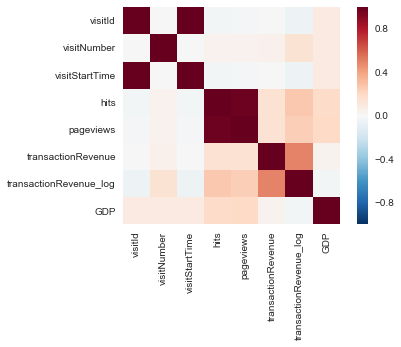

In [64]:
cor = newdf.corr() 
sns.heatmap(cor, square = True) 

C:\Users\rajes\Anaconda2\lib\site-packages\scipy\stats\stats.py:1633: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



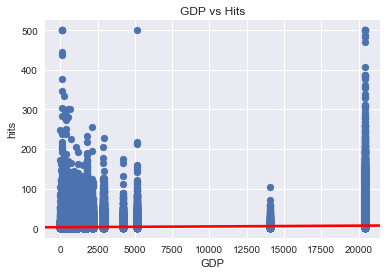

In [65]:
plt.title ('GDP vs Hits')
plt.xlabel('GDP in dollars')
plt.ylabel('Hits')
plt.scatter(newdf['GDP'],newdf['hits'])
sns.regplot(x = newdf['GDP'], y = newdf['hits'], scatter=False, color ='red')
plt.show()

## 6. Prediction Model

###  a) Using XGBRegressor

In [66]:
%%time
from xgboost import XGBRegressor
from sklearn.cross_validation import train_test_split

#copy contents of df
dfPredict = df.copy()
dfTest = test_data.copy()

#Label to predict
y_reg = dfPredict['transactionRevenue_log'].fillna(0)
#y_reg

Wall time: 1.08 s


In [67]:
excluded_features = [ 'fullVisitorId', 'sessionId', 'transactionRevenue', 
    'visitId', 'visitStartTime', 'transactionRevenue_log','visits', 'visitNumber', 'isTrueDirect', 
          'adContent','networkDomain','isVideoAd','gclId','slot', 'adNetworkType','keyword','referralPath', 'page'
]

categorical_features = [
    _f for _f in dfPredict.columns
    if (_f not in excluded_features) & (dfPredict[_f].dtype == 'object')
]

for f in categorical_features:
    dfPredict[f], indexer = pd.factorize(dfPredict[f])
    dfTest[f] = indexer.get_indexer(dfTest[f])  

In [68]:
dfPredict[train_features].count()

NameError: name 'train_features' is not defined

In [ ]:
#features to train on
train_features = [_f for _f in dfPredict.columns if _f not in excluded_features]
dfPredict[train_features].shape

In [ ]:
cor = dfPredict[train_features].corr() 
#print cor
sns.heatmap(cor, square = True) 

In [ ]:
%%time
X_train, X_test, Y_train, Y_test = train_test_split(dfPredict[train_features] ,y_reg, test_size=0.2)

In [ ]:
xgb = XGBRegressor()
xgb.fit(X_train, Y_train, eval_metric='rmse',verbose=100)

In [ ]:
%%time
ypredXGB = xgb.predict(X_test)

In [ ]:
ypredXGB[ypredXGB < 0] =0
ypredXGB

In [ ]:
from sklearn.metrics import mean_squared_error
import math

print("XGBoost: sqrt  ", math.sqrt(mean_squared_error(Y_test, ypredXGB)))

In [ ]:
print X_train.shape
# print test_data[train_features].shape

In [ ]:
my_regression_op = xgb.predict(dfTest[train_features])

In [ ]:
my_regression_op[my_regression_op < 0] =0
my_regression_op

In [ ]:
fullVisitorId = test_data['fullVisitorId']

In [ ]:
# submit to csv file for kaggle submission
submit1 = pd.DataFrame({'fullVisitorId': fullVisitorId,'PredictedLogRevenue':my_regression_op},columns=['fullVisitorId','PredictedLogRevenue'])

In [ ]:
submit1 = submit1.groupby('fullVisitorId').sum().reset_index()

# display user vs transaction for predicted values
plt.figure(figsize=(8,6))
plt.scatter(range(submit1.shape[0]), np.sort((submit1["PredictedLogRevenue"].values)))
plt.xlabel('Index', fontsize=14)
plt.ylabel('Transaction Revenue', fontsize=14)
plt.show()

In [ ]:
submit1.head()

In [ ]:
submit1.shape

### b) Using Light GBM

In [ ]:
%%time
import lightgbm as lgb

model = lgb.LGBMRegressor()
model.fit(X_train, Y_train, eval_metric='rmse', verbose=1000)
y_predLGBM = model.predict(X_test)   

In [ ]:
lgb.plot_importance(model, max_num_features=30);

In [ ]:
%%time
y_predLGBM[y_predLGBM < 0] =0
y_predLGBM

#RMSE
print("Light GBM: RMSE  ", math.sqrt(mean_squared_error(Y_test, y_predLGBM)))

In [ ]:
my_regression_op2 = model.predict(dfTest[train_features], num_iteration=model.best_iteration_)
my_regression_op2[my_regression_op2 < 0] =0
my_regression_op2

In [ ]:
submit2 = pd.DataFrame({'fullVisitorId': fullVisitorId,'PredictedLogRevenue':my_regression_op2},columns=['fullVisitorId','PredictedLogRevenue'])

In [ ]:
submit2 = submit2.groupby('fullVisitorId').sum().reset_index()

plt.figure(figsize=(8,6))
plt.scatter(range(submit2.shape[0]), np.sort((submit2["PredictedLogRevenue"].values)))
plt.xlabel('Index', fontsize=14)
plt.ylabel('Transaction Revenue', fontsize=14)
plt.show()

In [ ]:
# file for kaggle submission
submit2.to_csv("banani_sub2.csv",index=False)

## 7. Permutation Test

In [ ]:
from sklearn.utils import shuffle

# function to shuffle values in 1 column
def shuf(df, col, n):
    a = df[col]
    df.drop(col, axis=1, inplace=True)  
    for i in range(n):
        a = shuffle(a)
    a = a.reset_index()
    #print a
    df[col] = a[col]
    return df

#### Variable 1 - Country

In [ ]:
%%time
permDf = X_train.copy()
rmse = []

# permuation function
for i in range(300):
    shuf(permDf, 'country', 10)
    model.fit(permDf, Y_train, eval_metric='rmse', verbose=1000)
    y_permute = model.predict(X_test)   
    y_permute[y_permute < 0] =0
    #print("RMSE: ",i,  math.sqrt(mean_squared_error(y_test, y_permute)))
    rmse.append(math.sqrt(mean_squared_error(Y_test, y_permute)))
    permDf = X_train.copy()

In [ ]:
# rmse

In [ ]:
# plotting the permutation function
rmse1 = rmse
print(len(rmse1))
plt.figure(figsize=(5,5))
sns.distplot(rmse1)
plt.show()

In [ ]:
# p values= is  (0+1)/301 = 0.0033

#### Variable 2 - Operating System

In [ ]:
%%time
permDf = X_train.copy()
rmse2 = []
for i in range(1):
    shuf(permDf, 'operatingSystem', 10)
    model.fit(permDf, Y_train, eval_metric='rmse', verbose=1000)
    y_permute = model.predict(X_test)   
    y_permute[y_permute < 0] =0
    #print("RMSE: ",i,  math.sqrt(mean_squared_error(y_test, y_permute)))
    rmse2.append(math.sqrt(mean_squared_error(Y_test, y_permute)))
    permDf = X_train.copy()

In [ ]:
count=1
for i in rmse:
    if(i < 1.62):
        count = count+1
pval = count/301        
print ("%.2f" % (pval)) 
# p values= is  (0+1)/301 = 0.0033

In [ ]:
rmse
# p values= is  (0+1)/301 = 0.0033

In [ ]:
rmse_2 = rmse
print(len(rmse_2))
plt.figure(figsize=(5,5))
sns.distplot(rmse_2)
plt.show()

#### Variable 3 - Medium

In [ ]:
%%time
permDf = X_train.copy()
rmse2 = []
for i in range(5):
    shuf(permDf, 'medium', 300)
    model.fit(permDf, Y_train, eval_metric='rmse', verbose=1000)
    y_permute = model.predict(X_test)   
    y_permute[y_permute < 0] =0
    #print("RMSE: ",i,  math.sqrt(mean_squared_error(y_test, y_permute)))
    rmse2.append(math.sqrt(mean_squared_error(Y_test, y_permute)))
    permDf = X_train.copy()

In [ ]:
# p values= is  (0+1)/301 = 0.0033